<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/GANS_IN_ACTION_Chapter_4_DCGAN(Edited_withoutBatchNorm2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장: 심층 합성곱 GAN (DCGAN)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-4/Chapter_4_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
import tensorflow as tf
#print("TensorFlow version: ", tf.__version__)
#tf.debugging.set_log_device_placement(True)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
#os.environ["CUDA_VISIBLE_DEVICES"]='0'

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13067212206486379820
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16586937230332707304
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [2]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

# generator = build_generator(z_dim)
# generator.summary()


## 판별자

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))
    
    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## 모델 만들기

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
generator = build_generator(z_dim)
#generator.summary()
optimizer_g = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()

@tf.function
def train_step(z, real):
    with tf.GradientTape() as tape:
        gen_imgs = generator(z)
        pred = discriminator(gen_imgs)
        loss = tf.keras.losses.binary_crossentropy(real, pred) #? real or fake?

    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients, generator.trainable_variables))

    train_loss(loss)
    g_loss = train_loss.result()
    
    return gen_imgs, g_loss

# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# # 생성자 모델 만들기
# generator = build_generator(z_dim)

# # 생성자를 훈련하는 동안 판별자의 파라미터를 유지
# discriminator.trainable = False

# # 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
# gan = build_gan(generator, discriminator)
# gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()
    #(X_train, _), (_, _) = fashion_mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    import time
    start = time.time()  # 시작 시간 저장        

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        # gen_imgs = generator.predict(z)

        # 생성자 훈련?
        gen_imgs, g_loss = train_step(z, real)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        # z = np.random.normal(0, 1, (batch_size, 100))
        # gen_imgs = generator.predict(z)

        # 생성자 훈련
        # g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## GAN 훈련과 출력 점검

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.007654, 정확도: 99.61%] [G 손실: 8.293419]
time : 63.76510238647461


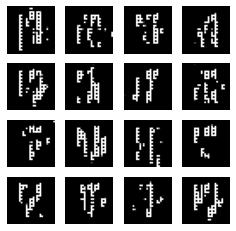

2000 [D 손실: 0.000003, 정확도: 100.00%] [G 손실: 9.897297]
time : 115.05613470077515


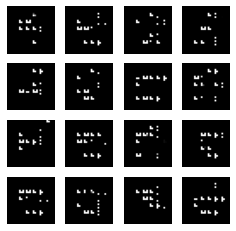

3000 [D 손실: 0.000013, 정확도: 100.00%] [G 손실: 10.743580]
time : 166.1504499912262


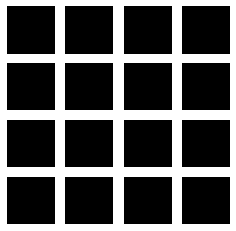

4000 [D 손실: 0.000001, 정확도: 100.00%] [G 손실: 11.070835]
time : 216.83118748664856


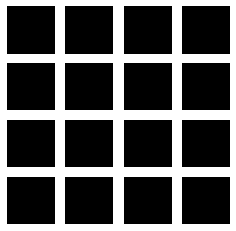

5000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 11.653472]
time : 267.68954205513


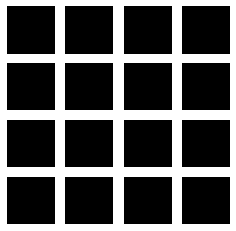

6000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 12.222992]
time : 318.7979187965393


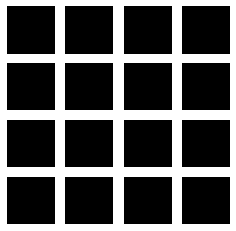

7000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 12.813375]
time : 369.5846993923187


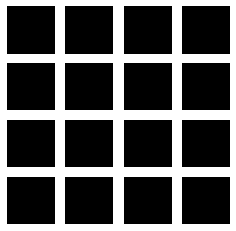

8000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 13.411242]
time : 420.51869559288025


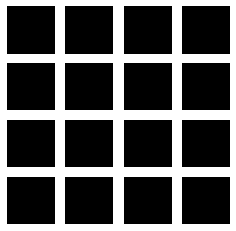

9000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 13.975986]
time : 471.2001254558563


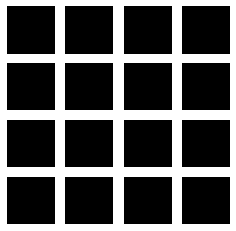

10000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 14.519492]
time : 521.7693769931793


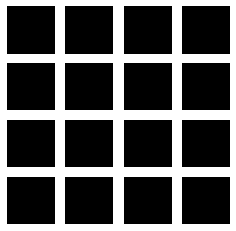

11000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 15.054122]
time : 572.2763743400574


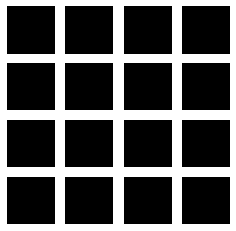

12000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 15.563137]
time : 622.9153563976288


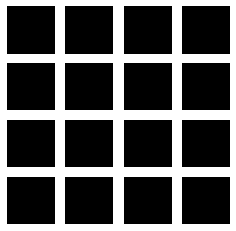

13000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 16.054659]
time : 673.5442142486572


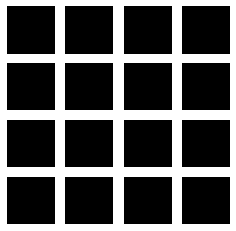

14000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 16.529366]
time : 724.2826180458069


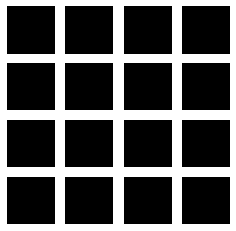

15000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 16.983942]
time : 774.6373496055603


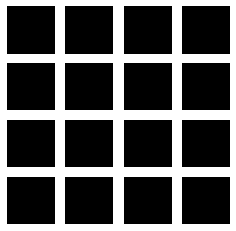

16000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 17.435465]
time : 825.0067801475525


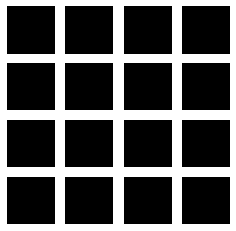

17000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 17.873711]
time : 875.4918789863586


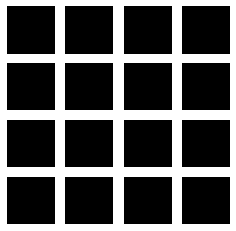

18000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 18.285830]
time : 925.924284696579


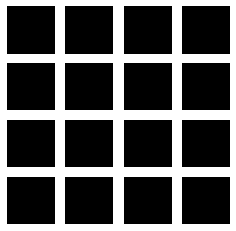

19000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 18.670042]
time : 976.3166537284851


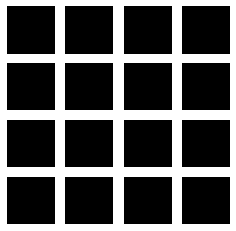

20000 [D 손실: 0.000000, 정확도: 100.00%] [G 손실: 19.030235]
time : 1027.097220659256


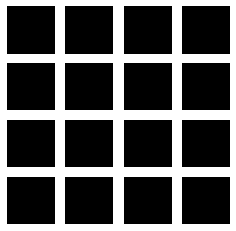

In [9]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)

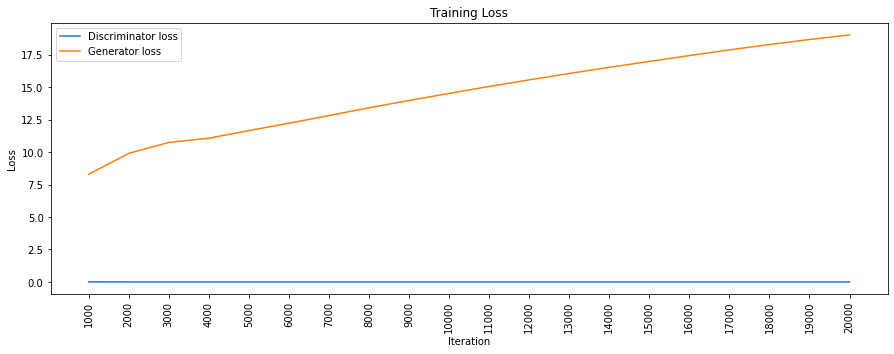

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

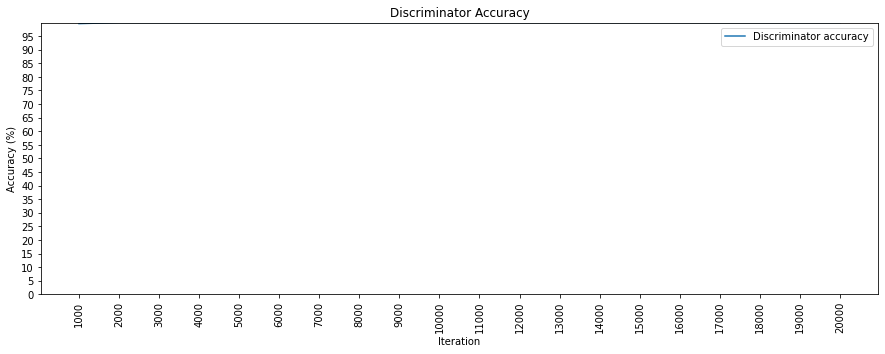

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()